# **Face Alignment**

## **Thử nghiệm**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/MyDrive/EVN_ICT/ArcFace'

Mounted at /content/drive
/content/drive/MyDrive/EVN_ICT/ArcFace


In [2]:
!pip install face_alignment facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.3 MB/s eta 0:00:00
  Created wheel for face_alignment: filename=face_alignment-1.3.5-py2.py3-none-any.whl size=28242 sha256=a96654efe623c6f821613451088383a301be32c1e11e71cae251c6e9b94f6082
  Stored in directory: /root/.cache/pip/wheels/32/21/d8/7bf61c86e3a6c5af8f118708d4c9c26512dbd1c913a0b97c8a
Successfully built face_alignment


In [3]:
import face_alignment
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import torch
from google.colab.patches import cv2_imshow


In [4]:
device =  torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Thresholds chính là mức thresholds cho 3 lớp mạng P, R và O. 
# Mặc định sẽ là [0.6, 0.7, 0.7] nhưng vì mình muốn tăng độ chính xác nên truyền 
# vào 3 mức cao hơn như trên. Keep_all để xác định việc chúng ta có detect và 
# trả về tất cả các mặt có thể trong bức hình hay không, mình muốn nên để giá trị True.
mtcnn = MTCNN(thresholds= [0.7, 0.7, 0.8] ,keep_all=True, device = device) 

In [5]:
# https://github.com/1adrianb/face-alignment
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, face_detector='sfd',  device='cpu') # or 'cuda'

# input = io.imread('./data/face/2/image_8_229.png')
# input = io.imread('./data/1.jpg')


Downloading: "https://www.adrianbulat.com/downloads/python-fan/s3fd-619a316812.pth" to /root/.cache/torch/hub/checkpoints/s3fd-619a316812.pth


  0%|          | 0.00/85.7M [00:00<?, ?B/s]

Downloading: "https://www.adrianbulat.com/downloads/python-fan/2DFAN4-cd938726ad.zip" to /root/.cache/torch/hub/checkpoints/2DFAN4-cd938726ad.zip


  0%|          | 0.00/91.9M [00:00<?, ?B/s]

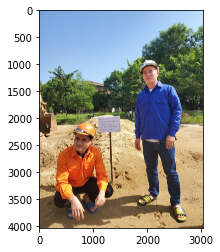

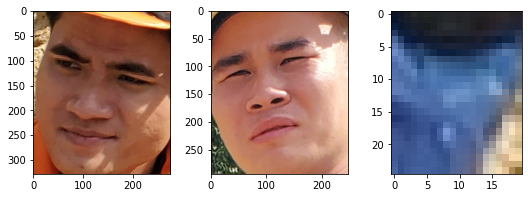

In [6]:
path_image = './data/7.jpg'
image = cv2.imread(path_image)
arr_face = []

boxes, _ = mtcnn.detect(image)
if boxes is not None:
    for box in boxes:
        bbox = list(map(int, box.tolist()))
        arr_face.append(image[bbox[1]:bbox[3], bbox[0]:bbox[2]])
        # frame = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 0, 255), 6)

arr_face = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in arr_face]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
n = len(arr_face)
fig, ax = plt.subplots(1, n, figsize=(3*n, 3))
for i in range(n):
    ax[i].imshow(arr_face[i])

plt.show()

In [7]:
boxes = [list(map(int, box.tolist())) for box in boxes]

In [8]:
boxes

[[637, 2277, 913, 2605], [1913, 1054, 2160, 1348], [2195, 3364, 2215, 3389]]

In [9]:
bbox = boxes[1]
input = image[bbox[1]:bbox[3], bbox[0]:bbox[2]]
preds = fa.get_landmarks(input)

In [10]:
landmarks = preds[0].astype(int)

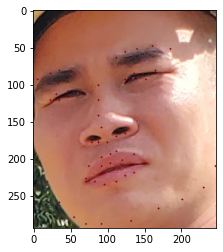

In [11]:
input_draw = input.copy()
for i, landmark in enumerate(landmarks):
    p = tuple(landmark)
    input_draw = cv2.circle(input_draw, p, 1, (18, 8, 140), -1) # cv2.circle(image, center_coordinates, radius, color, thickness)

    # Using cv2.putText() method
    # if i == 60:
    #   input_draw = cv2.putText(input_draw, str(i), p, cv2.FONT_HERSHEY_SIMPLEX, 
    #                          0.2, (18, 8, 140), 1, cv2.LINE_AA)

plt.imshow(cv2.cvtColor(input_draw, cv2.COLOR_BGR2RGB))


In [ ]:
# Tọa độ của các landmarks tuân theo quy tắc:
# 0 ---------------------> x
# |
# |
# |
# |
# |
# |
# v
# y

In [ ]:
landmarks

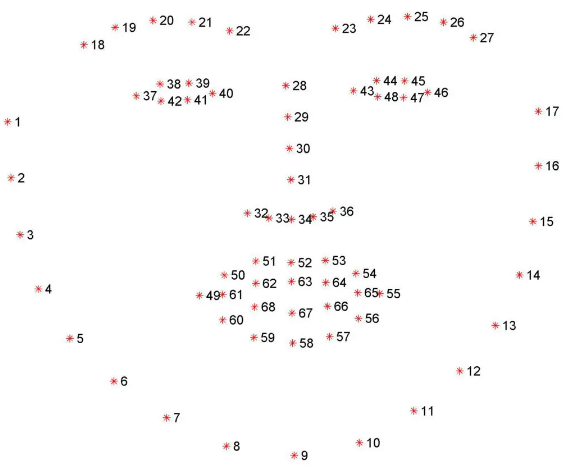

https://pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

In [12]:
class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35), desiredFaceWidth=256, desiredFaceHeight=None):
        '''
        predictor: mô hình dự đoán landmark
        desiredLeftEye: ước lượng vị trí mắt trái mong muốn (chuẩn hóa về đoạn [0, 1]), 
                        thông số này quyết định diện tích khuôn mặt có trong box sau khi alignment,
                        thông số này càng lớn, phần khuôn mặt càng xuất hiện nhiều trong box,
                        tùy thuộc vào ứng dụng thực tế khác nhau mà cần phần diện tích khuôn mặt khác nhau
        desiredFaceWidth, desiredFaceHeight: ước lượng kích thước khuôn mặt mong muốn sau khi alignment
        '''
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        if desiredFaceHeight is None:
          self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, rect):
        '''
        image: ảnh RGB ban đầu (chứa cả người)
        rect: tọa độ khuôn mặt đã được trích xuất
        '''
        face = image[rect[1]:rect[3], rect[0]:rect[2]]
        pred = self.predictor.get_landmarks(face)
        landmarks = pred[0].astype(int)
        # lấy các landmarks của mắt trái và mắt phải
        leftEyePts = landmarks[36:42]
        rightEyePts = landmarks[42:48]

        # Tính góc nghiêng của mặt, dựa vào góc nghiêng của đường thằng nối tâm hai mắt
        leftEyeCenter = leftEyePts.mean(axis=0).astype(int)
        rightEyeCenter = rightEyePts.mean(axis=0).astype(int)

        # nếu tọa độ y của mắt trái lớn hơn mắt phải -> dY âm -> góc quay âm
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]

        angle = np.degrees(np.arctan2(dY, dX))

        # Tính tọa độ X mong muốn của mắt phải (do mắt phải và mắt trái đối xứng nên có thể tính dựa vào mắt trái)
        desiredRightEyeX = 1 - self.desiredLeftEye[0]
        # khoảng cách hiện tại giữa mắt trái và mắt phải
        dist = np.sqrt(dX**2 + dY**2)
        # khoảng cách mong muốn giữa mắt trái và mắt phải sau khi alignment
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0]) * self.desiredFaceWidth

        # từ hai thông số trên ta tìm được scale
        scale = desiredDist / dist

        # tính toán điểm giữa hai mắt, khuôn mặt sẽ quay một góc quanh điểm này
        eyesCenter = [(leftEyeCenter[0] + rightEyeCenter[0])/2, (leftEyeCenter[1] + rightEyeCenter[1])/2]
        # tính lại tọa độ điểm giữa hai mắt theo ảnh gốc ban đầu
        eyesCenter[0] += rect[0]
        eyesCenter[1] += rect[1]
        # print(eyesCenter)
        
        # thực hiện affine transformation: phép biến đổi này bảo toàn các đoạn thẳng, khoảng cách tỉ lệ và tính song song
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale) # (center, angle, scale), góc dương sẽ quay ngược chiều kim đồng hồ, góc âm quay cùng chiều kim đồng hồ

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]

        # Dịch điểm giữa hai mắt thành gốc tọa độ, rồi tinh chỉnh lại để lấy ra được kích thước khuôn mặt mong muốn
        # dựa vào thành phần thứ ba của mỗi hàng trong ma trận, thành phần này được nhân với 1, nên ta có thể dịch ảnh
        # về tọa độ khác theo mong muốn
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # dsize = image.shape[:2]
        dsize=(self.desiredFaceWidth, self.desiredFaceHeight)
        rotated_image = cv2.warpAffine(src=image, M=M, dsize=dsize, flags=cv2.INTER_CUBIC)

        return rotated_image


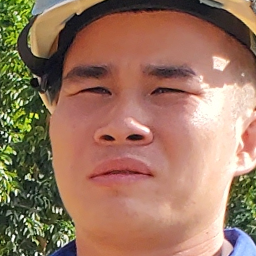

In [13]:
predictor = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False, face_detector='sfd',  device='cpu')
fa = FaceAligner(predictor, desiredFaceWidth=256)

faceAligned = fa.align(image, bbox)
cv2_imshow(faceAligned)

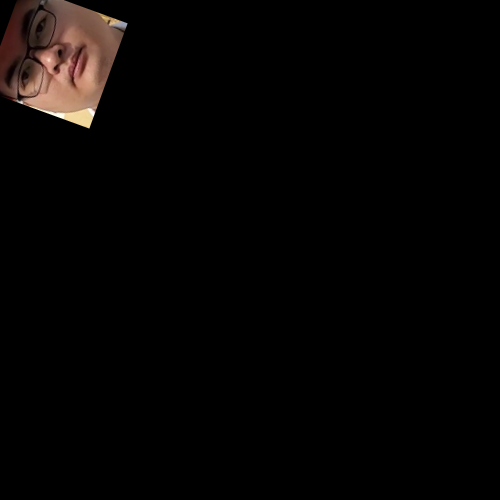

In [ ]:
image = cv2.imread('./data/face/2/image_8_233.png')
height, width = image.shape[:2]
center = (width/2, height/2)
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=70, scale=1)
rotated_image = cv2.warpAffine(
    src=image, M=rotate_matrix, dsize=(500, 500)) # dsize - kích thước ảnh cắt ra tính từ gốc tọa độ
  
cv2_imshow(rotated_image)

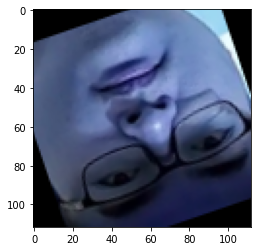

In [ ]:
image_test = cv2.imread('./data/face/2/image_8_233.png')
height, width = image_test.shape[:2]
center = (width/2, height/2)
rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=-161.12345, scale=1)
rotated_image = cv2.warpAffine(
    src=image_test, M=rotate_matrix, dsize=(width, height))
  
plt.imshow(rotated_image)

## **Lý thuyết Geometric Transformation: Rotation**

Giả sử ta có điểm P(x, y) nằm ở góc alpha so với trục x và cách gốc tọa độ một đoạn r. Ta quay điểm P một góc theta để thu được P'

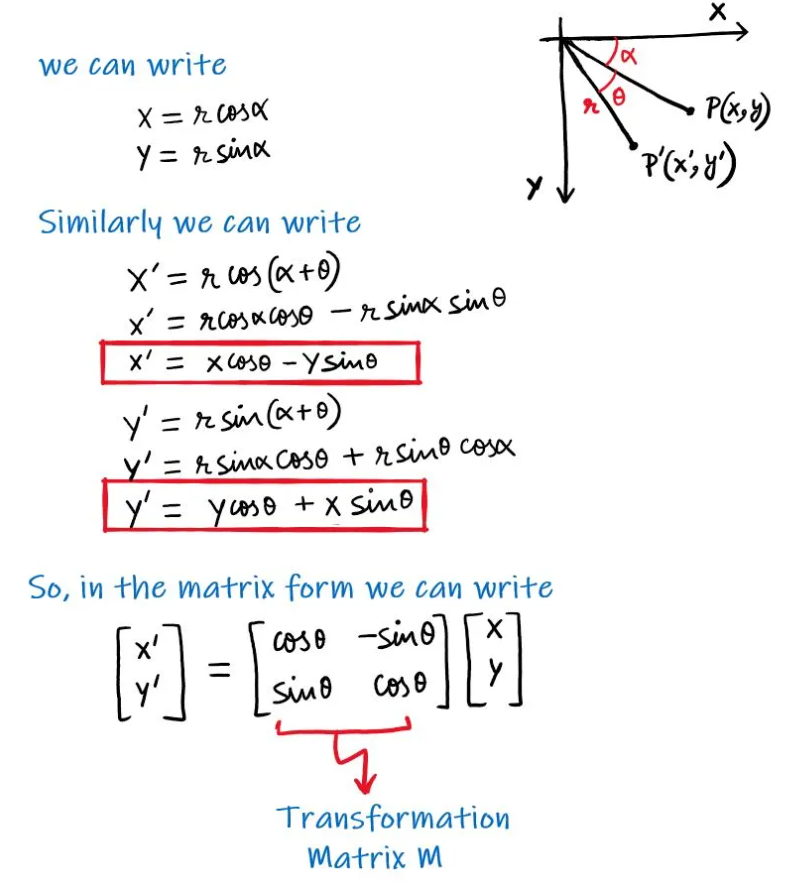

Trong trường hợp muốn quay điểm P quanh một điểm khác không phải gốc tọa độ:

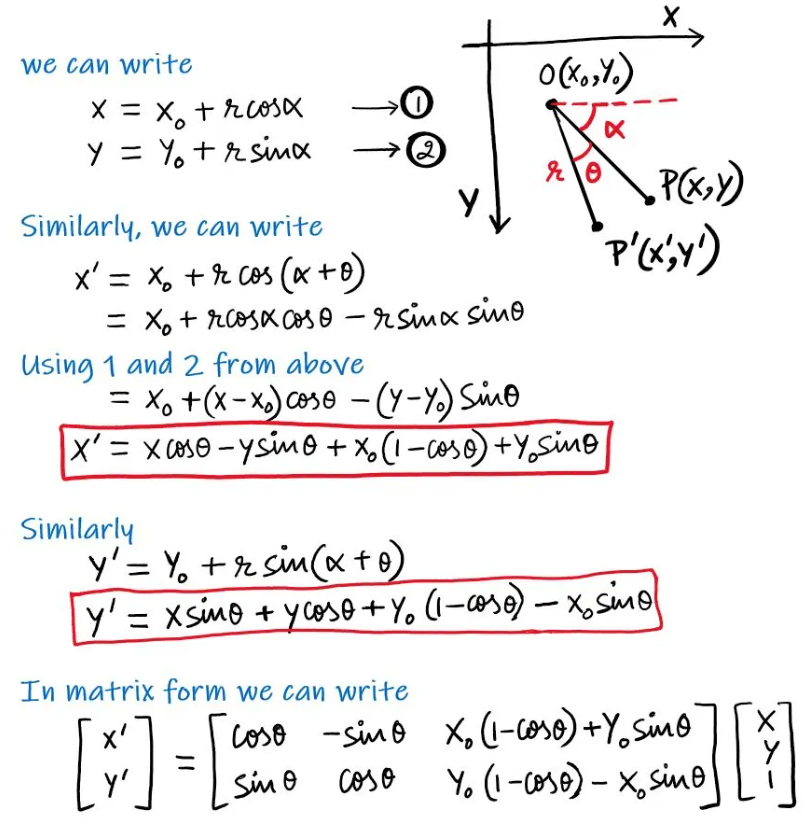

Chú ý: 
- Các phương trình trên chỉ đúng cho trường hợp góc quay theta cùng chiều kim đồng hồ
- Trong OpenCV có thêm tham số scale, tham số này sẽ nhân với các phần tử trong ma trận M


```
transform_matrix = cv2.getRotationMatrix2D(center, angle, scale)
 
#center: Center of the rotation in the source image.
#angle: Rotation angle in degrees. Positive values mean counter-clockwise rotation (the coordinate origin is assumed to be the top-left corner).
#scale:	Isotropic scale factor.
```


```
dst = cv.warpAffine(src, M, dsize[, dst[, flags[, borderMode[, borderValue]]]] )
 
# src: input image
# M: Transformation matrix
# dsize: size of the output image (kích thước ảnh cắt ra tính từ gốc tọa độ)
# flags: interpolation method to be used
```


